<a href="https://colab.research.google.com/github/93bhargavi/CreditcardFraud/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Using TensorFlow 1.2 and Keras 2.0.4.
 Import necessary libraries

In [7]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

In [8]:
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [9]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

 **Loading the Data**


 The dataset we're going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset

In [5]:
df = pd.read_csv("/content/creditcard.csv")


**Exploration**

In [6]:
df.shape

(120901, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:



In [7]:
df.isnull().values.any()

True

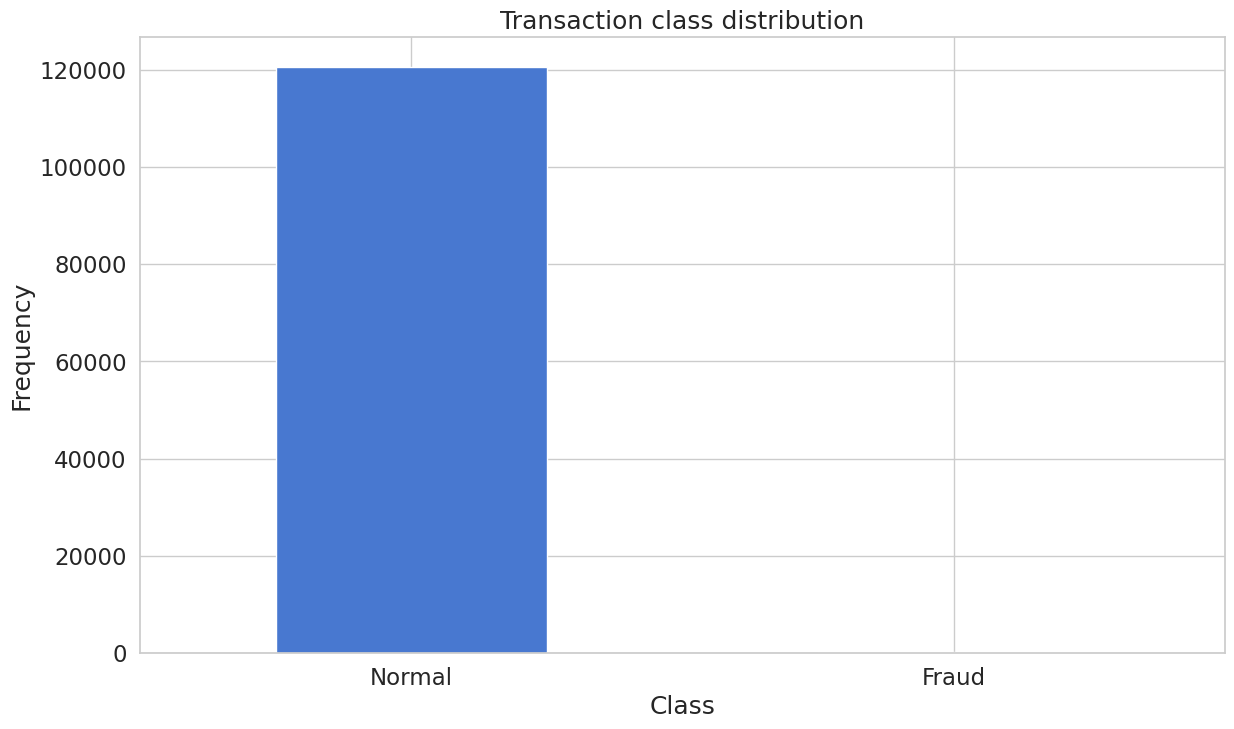

In [10]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:



In [11]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [12]:
frauds.shape

(249, 31)

In [13]:
normal.shape

(120651, 31)

How different are the amount of money used in different transaction classes?



In [14]:
frauds.Amount.describe()

count     249.000000
mean      119.180482
std       251.160611
min         0.000000
25%         1.000000
50%        11.390000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [15]:
normal.Amount.describe()


count    120651.000000
mean         94.185676
std         255.770139
min           0.000000
25%           6.885000
50%          24.990000
75%          84.815000
max       19656.530000
Name: Amount, dtype: float64

Let's have a more graphical representation:



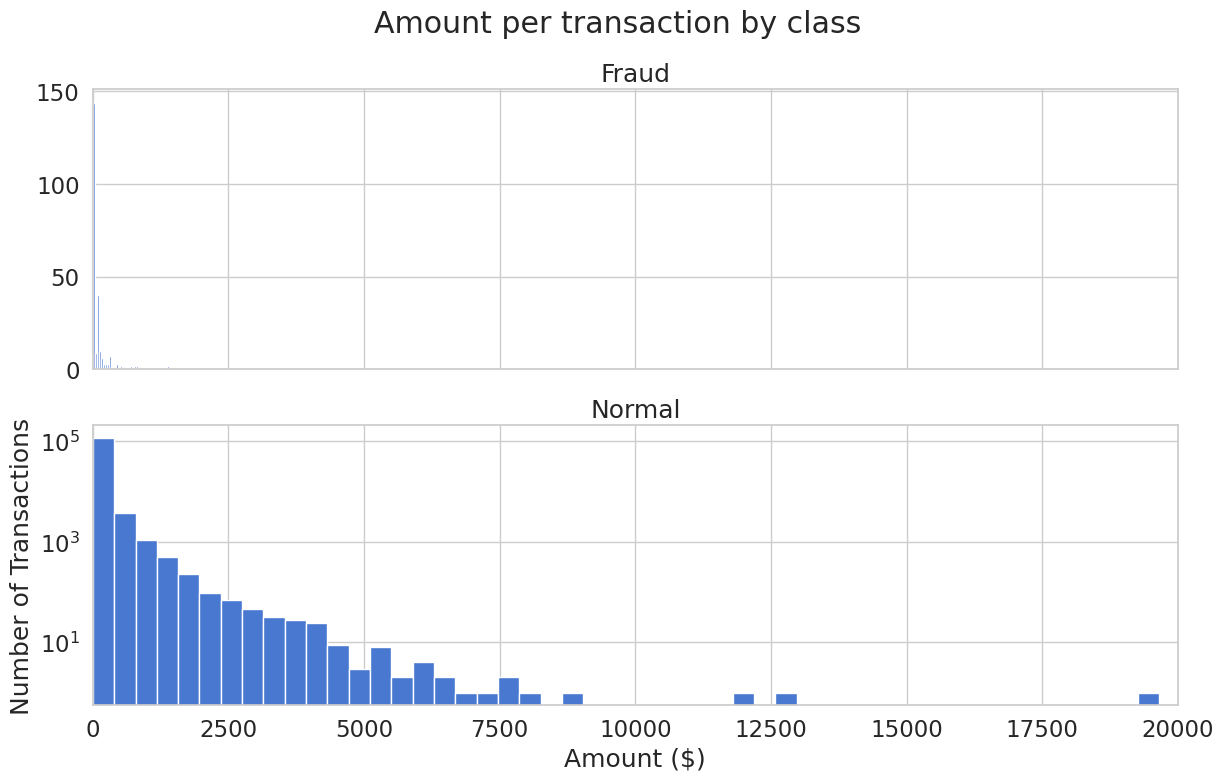

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?



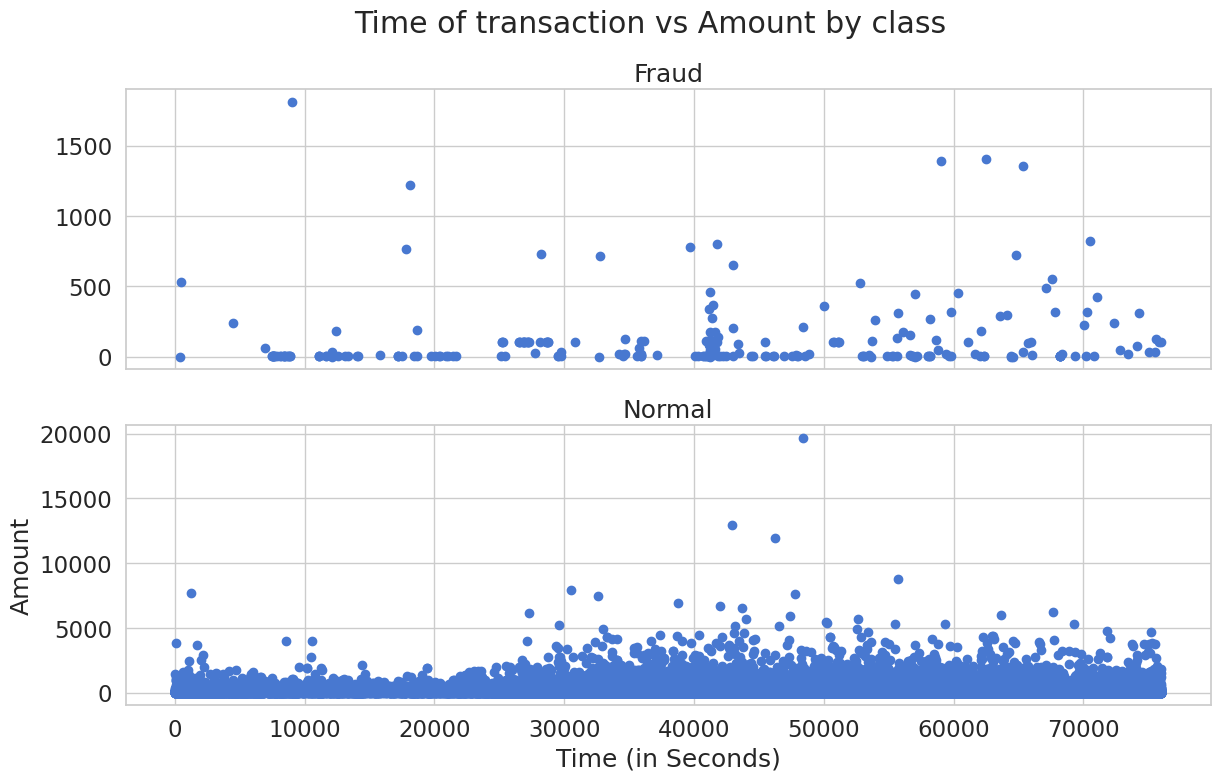

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

 **Preparing the data**

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [19]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training old dataset.Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [20]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [21]:
X_train.shape


(96531, 29)

**` Building the model`**

In [22]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [23]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [24]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
3017/3017 [==============================] - 9s 3ms/step - loss: 0.8189 - accuracy: 0.4752 - val_loss: nan - val_accuracy: 0.5437
Epoch 2/100
3017/3017 [==============================] - 13s 4ms/step - loss: 0.7371 - accuracy: 0.5735 - val_loss: nan - val_accuracy: 0.5901
Epoch 3/100
3017/3017 [==============================] - 12s 4ms/step - loss: 0.7140 - accuracy: 0.6245 - val_loss: nan - val_accuracy: 0.6642
Epoch 4/100
3017/3017 [==============================] - 16s 5ms/step - loss: 0.6954 - accuracy: 0.6749 - val_loss: nan - val_accuracy: 0.6845
Epoch 5/100
3017/3017 [==============================] - 11s 4ms/step - loss: 0.6867 - accuracy: 0.6863 - val_loss: nan - val_accuracy: 0.6897
Epoch 6/100
3017/3017 [==============================] - 14s 5ms/step - loss: 0.6822 - accuracy: 0.6945 - val_loss: nan - val_accuracy: 0.6992
Epoch 7/100
3017/3017 [==============================] - 12s 4ms/step - loss: 0.6786 - accuracy: 0.6996 - val_loss: nan - val_accuracy: 0.7057


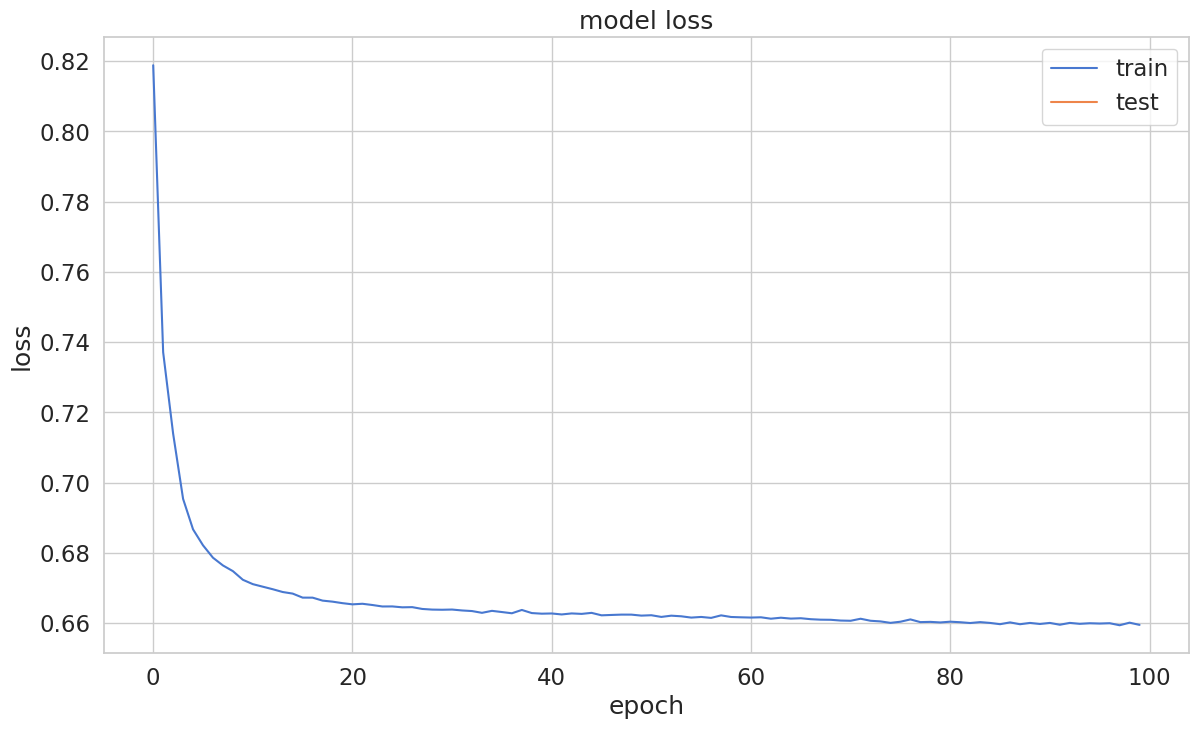

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');